In [1]:
import sys
sys.path.append('/Users/omarschall/vanilla-rtrl/')
import numpy as np
from network import *
from simulation import *
from gen_data import *
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    pass
from optimizers import *
from analysis_funcs import *
from learning_algorithms import *
from functions import *
from itertools import product
import os
import pickle
from copy import deepcopy
from scipy.ndimage.filters import uniform_filter1d
from sklearn import linear_model
from state_space import *
from dynamics import *
import multiprocessing as mp
from functools import partial
from sklearn.cluster import DBSCAN
%matplotlib notebook

In [2]:
np.random.seed(0)
task = Flip_Flop_Task(3, 0.05, tau_task=1)
N_train = 100000
N_test = 10000
data = task.gen_data(N_train, N_test)
with open('good_ones/bptt_fave', 'rb') as f:
    sim = pickle.load(f)

In [8]:
norm(sim.checkpoints[15010]['rnn'].W_rec - sim.checkpoints[15010]['rnn'].W_rec)

0.1335393923868752

In [20]:
### SAVE ###
with open('good_ones/bptt_fave', 'wb') as f:
    pickle.dump(sim, f)

In [4]:
def analyze_checkpoint(checkpoint, N_iters=8000,
                       same_LR_criterion=5000, N=200, **kwargs):
    
    print('Analyzing checkpoint {}...'.format(checkpoint['i_t']))
    
    rnn = checkpoint['rnn']
    test_sim = Simulation(rnn)
    test_sim.run(data,
                  mode='test',
                  monitors=['rnn.loss_', 'rnn.y_hat', 'rnn.a'],
                  verbose=False)
    
    transform = Vanilla_PCA(checkpoint, data)
    V = transform(np.eye(rnn.n_h))

    fixed_points, initial_states = find_KE_minima(checkpoint, data, N=N,
                                                  N_iters=N_iters, LR=10,
                                                  same_LR_criterion=same_LR_criterion,
                                                  **kwargs)
    
    A = np.array([d['a_final'] for d in fixed_points])
    A_init = np.array(initial_states)
    KE = np.array([d['KE_final'] for d in fixed_points])
    
    dbscan = DBSCAN(eps=0.5)
    dbscan.fit(A)
    dbscan.labels_
    
    cluster_idx = np.unique(dbscan.labels_)
    n_clusters = len(cluster_idx) - (-1 in cluster_idx)
    cluster_means = np.zeros((n_clusters, rnn.n_h))
    for i in cluster_idx:
        
        if i == -1:
            continue
        else:
            cluster_means[i] = A[dbscan.labels_ == i].mean(0)
    
    cluster_eigs = []
    cluster_KEs = []
    for cluster_mean in cluster_means:
        checkpoint['rnn'].reset_network(a=cluster_mean)
        a_J = checkpoint['rnn'].get_a_jacobian(update=False)
        cluster_eigs.append(np.abs(np.linalg.eig(a_J)[0][0]))
        KE = checkpoint['rnn'].get_network_speed()
        cluster_KEs.append(KE)
    cluster_eigs = np.array(cluster_eigs)
    cluster_KEs = np.array(cluster_KEs)
    
    #Save results
    checkpoint['fixed_points'] = A
    checkpoint['KE'] = KE
    checkpoint['cluster_means'] = cluster_means
    checkpoint['cluster_labels'] = dbscan.labels_
    checkpoint['V'] = V
    checkpoint['A_init'] = A_init
    checkpoint['cluster_eigs'] = cluster_eigs
    checkpoint['cluster_KEs'] = cluster_KEs

In [5]:
def plot_checkpoint_results(checkpoint, ssa=None, plot_test_points=False,
                            plot_fixed_points=False, plot_cluster_means=False,
                            plot_uncategorized_points=False, plot_init_points=False,
                            eig_norm_color=False):
    
    rnn = checkpoint['rnn']
    test_sim = Simulation(rnn)
    test_sim.run(data,
                  mode='test',
                  monitors=['rnn.loss_', 'rnn.y_hat', 'rnn.a'],
                  verbose=False)
    
    A_init = checkpoint['A_init']
    fixed_points = checkpoint['fixed_points']
    labels = checkpoint['cluster_labels']
    cluster_means = checkpoint['cluster_means']
    cluster_eigs = checkpoint['cluster_eigs']
    
    if ssa is None:
        transform = partial(np.dot, b=checkpoint['V'])
        ssa = State_Space_Analysis(checkpoint, data, transform=transform)
    ssa.clear_plot()
    if plot_test_points:
        ssa.plot_in_state_space(test_sim.mons['rnn.a'][1000:], False, 'C0', '.', alpha=0.05)
    if plot_init_points:
        ssa.plot_in_state_space(A_init, False, 'C9', 'x', alpha=1)
    
    cluster_idx = np.unique(labels)
    n_clusters = len(cluster_idx) - (-1 in cluster_idx)
    for i in cluster_idx:
        
        if i == -1:
            color = 'k'
            if not plot_uncategorized_points:
                continue
        else:
            color = 'C{}'.format(i+1)
        if plot_fixed_points:
            ssa.plot_in_state_space(fixed_points[labels == i], False, color, '*', alpha=0.5)
    
    if plot_cluster_means:
        if eig_norm_color:
            ssa.plot_in_state_space(cluster_means[cluster_eigs<1], False, 'k', 'X', alpha=0.3)
            ssa.plot_in_state_space(cluster_means[cluster_eigs>1], False, 'k', 'o', alpha=0.3)
        else:
            ssa.plot_in_state_space(cluster_means, False, 'k', 'X', alpha=0.3)
            
    return ssa

In [12]:
for i_checkpoint in [20000]:
    analyze_checkpoint(sim.checkpoints[i_checkpoint], verbose=False, sigma_pert=0.5, N=500,
                       N_iters=4000, same_LR_criterion=3000)

Analyzing checkpoint 20000...
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 

Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion

Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion at 3006 iter
Reached same LR criterion

<IPython.core.display.Javascript object>


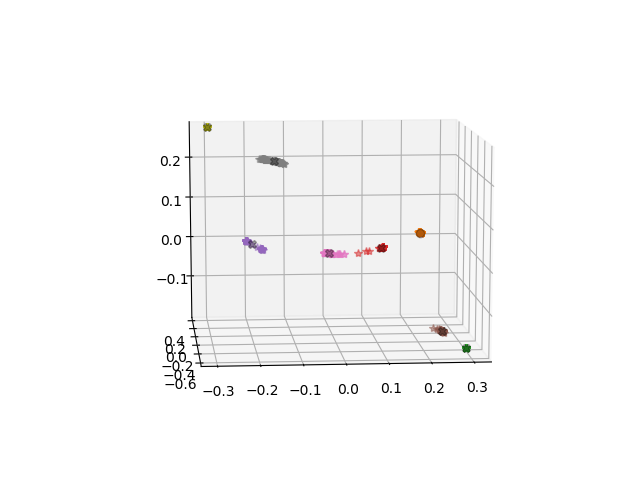

In [17]:
plot_checkpoint_results(sim.checkpoints[20000], plot_cluster_means=True,
                       plot_fixed_points=True, plot_uncategorized_points=False,
                       eig_norm_color=True)

In [21]:
sim.resume_sim_at_checkpoint(data, 10000, N=1, checkpoint_interval=10)

KeyError: 9999

In [19]:
sim.checkpoints.keys()

dict_keys([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 99999, 10010, 10020, 10030, 10040, 10050, 10060, 10070, 10080, 10090, 10100, 10110, 10120, 10130, 10140, 10150, 10160, 10170, 10180, 10190, 10200, 10210, 10220, 10230, 10240, 10250, 10260, 10270, 10280, 10290, 10300, 10310, 10320, 10330, 10340, 10350, 10360, 10370, 10380, 10390, 10400, 10410, 10420, 10430, 10440, 10450, 10460, 10470, 10480, 10490, 10500, 10510, 10520, 10530, 10540, 10550, 10560, 10570, 10580, 10590, 10600, 10610, 10620, 10630, 10640, 10650, 10660, 10670, 10680, 10690, 10700, 10710, 10720, 10730, 10740, 10750, 10760, 10770, 10780, 10790, 10800, 10810, 10820, 10830, 10840, 10850, 10860, 10870, 10880, 10890, 10900, 10910, 10920, 10930, 10940, 10950, 10960, 10970, 10980, 10990, 11000, 11010, 11020, 11030, 11040, 11050, 11060, 11070, 11080, 11090, 11100, 11110, 11120, 11130, 11140, 11150, 11160, 11170, 11180, 11190, 11200, 11210, 